In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from sklearn.ensemble import BaggingRegressor

import corner
import matplotlib.pyplot as plt
%matplotlib inline

## Functions to Relate Conditions to Samples

**Environment**
- A
- B
- C

**Geochem**
- pA
- pB
- pC

In [134]:
def fpA(A, B, C):
    return 1 #- 4 * B**(C * 0.1)

def fpB(A, B, C):
    return A + 8*B

def fpC(A, B, C):
    return C * 100

## Generate Synthetic Data

In [135]:
# synthetic environment
N = int(1e4)

A = np.random.uniform(1, 10, N)
B = np.random.uniform(1, 10, N)
C = np.random.uniform(1, 10, N)

# synthetic data
pA = fpA(A, B, C)
pB = fpB(A, B, C)
pC = fpC(A, B, C)

# combine datasets
env = pd.DataFrame({'A': A,
                    'B': B,
                    'C': C})
foram = pd.DataFrame({'pA': pA,
                      'pB': pB,
                      'pC': pC})

# add noise to foram
# foram *= np.random.normal(1, 0.0001, foram.shape)

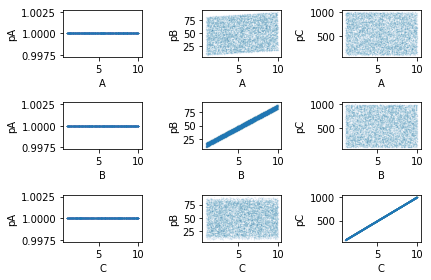

In [136]:
tt = 1
for i in env.columns:
    for j in foram.columns:

        plt.subplot(3,3,tt)
        plt.scatter(env[i],foram[j],s=0.1,alpha=0.1)
        plt.xlabel(i)
        plt.ylabel(j)
        tt = tt +1
        
plt.tight_layout()

## Data Wrangling

In [137]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

In [138]:
# create scalers and apply to data
env_scaler = StandardScaler()
foram_scaler = StandardScaler()

foram_scaler.fit(foram)
env_scaler.fit(env)

tenv = env_scaler.transform(env)
tforam = foram_scaler.transform(foram)

In [139]:
# split into test/training
tenv_train, tenv_test, tforam_train, tforam_test = model_selection.train_test_split(tenv, tforam, test_size=0.3)

## MLPRegressor

In [140]:
nn = MLPRegressor((100, 10, 10),solver='lbfgs',activation='tanh')
nn.fit(tforam_train, tenv_train)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [141]:
train_prediction = env_scaler.inverse_transform(nn.predict(tforam_train))

In [142]:
test_prediction = env_scaler.inverse_transform(nn.predict(tforam_test))

In [143]:
def limcalc(x, pad=0.05):
    rn = np.ptp(x)
    return np.nanmin(x) - rn * pad, np.nanmax(x) + rn * pad

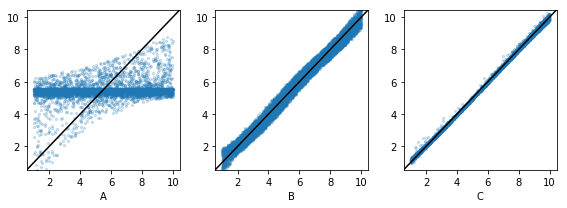

In [144]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

meas = env_scaler.inverse_transform(tenv_train)
pred = train_prediction

for i, (p, ax) in enumerate(zip(env.columns, axs.flat)):
    ax.set_xlabel(p)
    
    x = meas[:, i]
    y = pred[:, i]
    
    ax.scatter(x, y, alpha=0.2, s=5)
    
    mlim = limcalc(x)
    
    ax.set_xlim(mlim)
    ax.set_ylim(mlim)
    ax.plot(mlim, mlim, c='k')
    
fig.tight_layout()

In [157]:
s_m.to_rgba(pred[:,2])


array([[0.16862745, 0.83137255, 1.        , 1.        ],
       [0.1254902 , 0.8745098 , 1.        , 1.        ],
       [0.84705882, 0.15294118, 1.        , 1.        ],
       ...,
       [0.91372549, 0.08627451, 1.        , 1.        ],
       [0.9254902 , 0.0745098 , 1.        , 1.        ],
       [0.07058824, 0.92941176, 1.        , 1.        ]])

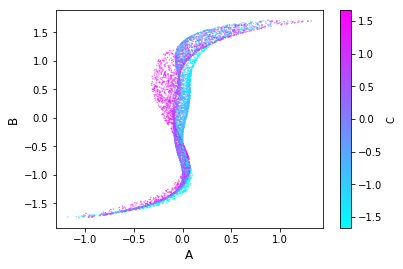

In [163]:
import matplotlib

plt.figure()

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(pred[:,2]),
    vmax=np.max(pred[:,2]))

# choose a colormap
c_m = matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


plt.scatter(pred[:,0],pred[:,1],s = 0.1,c=s_m.to_rgba(pred[:,2]))
plt.xlabel('A',fontsize=12)
plt.ylabel('B',fontsize=12)

# having plotted the 11 curves we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m)
c_bar.set_label(r"C")

plt.savefig('neuralnet_art.png')

## SVM

In [164]:
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor

In [165]:
sv = svm.SVR()

In [166]:
mo = MultiOutputRegressor(sv)

In [167]:
mo.fit(tforam_train, tenv_train)

MultiOutputRegressor(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
           n_jobs=1)

In [168]:
pred = mo.predict(tforam_train)

In [169]:
train_prediction = env_scaler.inverse_transform(pred)

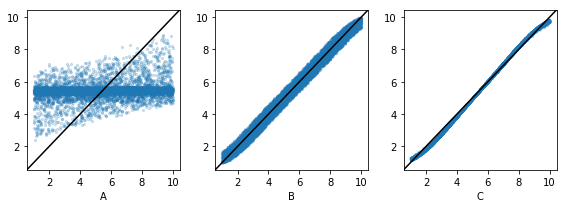

In [170]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

meas = env_scaler.inverse_transform(tenv_train)
pred = train_prediction

for i, (p, ax) in enumerate(zip(env.columns, axs.flat)):
    ax.set_xlabel(p)
    
    x = meas[:, i]
    y = pred[:, i]
    
    ax.scatter(x, y, alpha=0.2, s=5)
    
    mlim = limcalc(x)
    
    ax.set_xlim(mlim)
    ax.set_ylim(mlim)
    ax.plot(mlim, mlim, c='k')
    
fig.tight_layout()

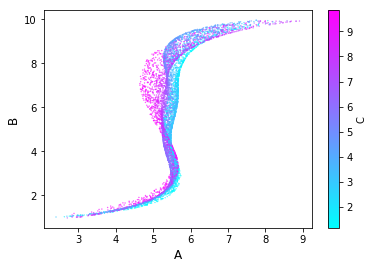

In [171]:
plt.figure()

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(pred[:,2]),
    vmax=np.max(pred[:,2]))

# choose a colormap
c_m = matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


plt.scatter(pred[:,0],pred[:,1],s = 0.1,c=s_m.to_rgba(pred[:,2]))
plt.xlabel('A',fontsize=12)
plt.ylabel('B',fontsize=12)

# having plotted the 11 curves we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m)
c_bar.set_label(r"C")

plt.savefig('neuralnet_art.png')

## Kernel Ridge

In [172]:
from sklearn.kernel_ridge import KernelRidge

In [173]:
kr = KernelRidge(kernel='rbf')

In [174]:
kr.fit(tforam_train, tenv_train)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)

In [175]:
pred = kr.predict(tforam_train)
train_prediction = env_scaler.inverse_transform(pred)

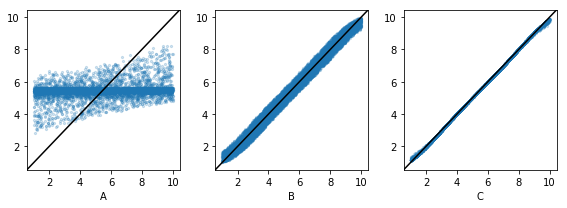

In [176]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

meas = env_scaler.inverse_transform(tenv_train)
pred = train_prediction

for i, (p, ax) in enumerate(zip(env.columns, axs.flat)):
    ax.set_xlabel(p)
    
    x = meas[:, i]
    y = pred[:, i]
    
    ax.scatter(x, y, alpha=0.2, s=5)
    
    mlim = limcalc(x)
    
    ax.set_xlim(mlim)
    ax.set_ylim(mlim)
    ax.plot(mlim, mlim, c='k')
    
fig.tight_layout()

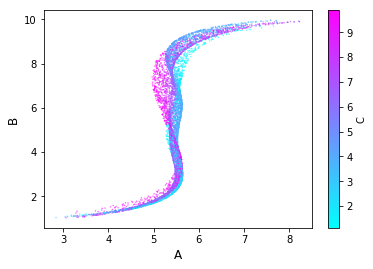

In [177]:
plt.figure()

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(pred[:,2]),
    vmax=np.max(pred[:,2]))

# choose a colormap
c_m = matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])


plt.scatter(pred[:,0],pred[:,1],s = 0.1,c=s_m.to_rgba(pred[:,2]))
plt.xlabel('A',fontsize=12)
plt.ylabel('B',fontsize=12)

# having plotted the 11 curves we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m)
c_bar.set_label(r"C")

plt.savefig('neuralnet_art.png')

## Keras

In [28]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

ModuleNotFoundError: No module named 'keras'

In [29]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal'))  # must be 3 because 3 in output array
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [30]:
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=larger_model, epochs=100, batch_size=200, verbose=0)

NameError: name 'KerasRegressor' is not defined

In [30]:
# K-fold validation... clever stuff.
# kfold = KFold(n_splits=5, random_state=42)
# results = cross_val_score(estimator, tforam_train, tenv_train, cv=kfold)
# print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [31]:
estimator.fit(tforam_train, tenv_train)

In [32]:
pred = estimator.predict(tforam_train)

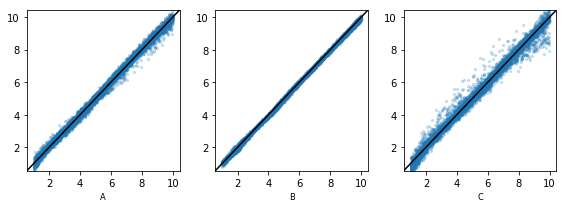

In [33]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

meas = env_scaler.inverse_transform(tenv_train)
pred = env_scaler.inverse_transform(pred)

for i, (p, ax) in enumerate(zip(env.columns, axs.flat)):
    ax.set_xlabel(p)
    
    x = meas[:, i]
    y = pred[:, i]
    
    ax.scatter(x, y, alpha=0.2, s=5)
    
    mlim = limcalc(x)
    
    ax.set_xlim(mlim)
    ax.set_ylim(mlim)
    ax.plot(mlim, mlim, c='k')
    
fig.tight_layout()